<a href="https://colab.research.google.com/github/IzaakGagnon/SSC_GliderProject/blob/main/JaidenTouchThis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [16]:
# Define the directory containing the glider CSV files
dataDir = "~/Final5P87/data/"  # Make sure ONLY the glider data is here
data_dir = "/content/drive/MyDrive/Glider data"
output_file = os.path.join(data_dir, "glider_data.csv")

# If the combined CSV file exists, delete it.
if os.path.exists(output_file):
    os.remove(output_file)
    print("Existing combined CSV removed:", output_file)

# Combine CSV files into one.
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
header_written = False

with open(output_file, 'w', newline='') as fout:
    for csv_file in csv_files:
        # Skip the output file (just in case)
        if os.path.abspath(csv_file) == os.path.abspath(output_file):
            continue
        with open(csv_file, 'r') as fin:
            header = fin.readline()
            if not header_written:
                fout.write(header)
                header_written = True
            for line in fin:
                fout.write(line)
print("CSV files combined successfully into:", output_file)

# Define paths for CSV and HDF5 files.
csv_file = output_file
hdf_file = os.path.join(data_dir, "glider_data.h5")

# If the HDF5 file exists, delete it.
if os.path.exists(hdf_file):
    os.remove(hdf_file)
    print("Existing HDF5 file removed:", hdf_file)

# Define data types to reduce memory usage.
dtypes = {
    "longitude": "float32",
    "latitude": "float32",
    "depth": "float32",
    "time": "str",         # Keep as string if date parsing is not required immediately
    "salinity": "float32",
    "density": "float32",
    "temperature": "float32"
}

chunksize = 10**6  # Adjust based on your available memory

# Optionally, define a function to regularize each chunk's format.
def regularize_chunk(chunk):
    # Mapping original column names to standard ones (if necessary).
    col_mapping = {
        "sea_water_temperature": "temperature",
        "sea_water_practical_salinity": "salinity",
        "sea_water_density": "density",
        "micromoles_of_oxygen_per_unit_mass_in_sea_water": "oxygen"
    }
    chunk.rename(columns=col_mapping, inplace=True)

    # Enforce consistent data types (numeric columns to float32)
    for col in ["latitude", "longitude", "depth", "temperature", "salinity", "density", "oxygen"]:
        if col in chunk.columns:
            chunk[col] = pd.to_numeric(chunk[col], errors='coerce').astype("float32")

    # PRUNE NEGATIVE OXYGEN ROWS:
    # Remove any rows where oxygen is negative
    if "oxygen" in chunk.columns:
        chunk = chunk[chunk["oxygen"] >= 0]

    return chunk

# Convert the combined CSV file into an HDF5 file using chunking.
with pd.HDFStore(hdf_file, mode='w') as store:
    for i, chunk in enumerate(pd.read_csv(csv_file, dtype=dtypes, chunksize=chunksize, low_memory=False)):
        # Regularize the chunk to ensure a consistent format.
        chunk = regularize_chunk(chunk)
        store.append('data', chunk, format='table', data_columns=True)
        print(f"Processed chunk {i}")
print("Conversion to HDF5 complete.")

# Read the HDF5 file and display the first few rows of data.
df = pd.read_hdf(hdf_file, 'data')
print("Head of combined data:")
print(df.head())

Existing combined CSV removed: /content/drive/MyDrive/Glider data/glider_data.csv


KeyboardInterrupt: 

In [21]:
# Uncomment and run the next line if mgwr is not already installed:
# !pip install mgwr

import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Glider data/fundy_20190604_99_delayed_corrected_v4.csv')
df = df.sample(frac=0.05, random_state=42)
# Inspect the first few rows and columns to confirm variable names
print("Dataset preview:")
print(df.head())
print("\nColumns in the dataset:", df.columns.tolist())

# -------------------------------
# Define your variables:
# -------------------------------
# We'll use 'sea_water_temperature' as the response variable.
# Exclude 'time', 'latitude', and 'longitude' from predictors.
response_variable = 'sea_water_temperature'
predictor_cols = [col for col in df.columns if col not in ['time', 'latitude', 'longitude', response_variable]]
print("\nResponse variable selected:", response_variable)
print("Predictor columns selected:", predictor_cols)

# Extract coordinates, response, and predictors
# Note: The coordinate order is typically [longitude, latitude]
coords = df[['longitude', 'latitude']].values
y = df[response_variable].values.reshape((-1, 1))
X = df[predictor_cols].values

# (Optional) Standardize predictors if needed
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# -------------------------------
# Bandwidth selection for GWR
# -------------------------------
bw_selector = Sel_BW(coords, y, X)
bw = bw_selector.search()
print("\nOptimal bandwidth selected:", bw)

# -------------------------------
# Fit the GWR model
# -------------------------------
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

# -------------------------------
# Output the results
# -------------------------------
print("\nGWR Model Summary:")
print(gwr_results.summary())

# Local parameter estimates for each observation
local_params = gwr_results.params
print("\nLocal parameter estimates (first 5 observations):")
print(local_params[:5])


Dataset preview:
                      time   latitude  longitude      depth  \
25758  2019-06-16 11:57:47  48.235059 -63.670107  49.137216   
628    2019-06-05 01:49:54  47.918986 -63.991413  77.757749   
26088  2019-06-16 15:25:44  48.236466 -63.652762  14.218884   
37788  2019-06-22 01:15:14  47.995146 -63.383954  38.223004   
9444   2019-06-09 03:56:27  47.844365 -63.190020  33.781840   

       sea_water_temperature  sea_water_practical_salinity  sea_water_density  \
25758               -0.11480                     31.373594        1025.425938   
628                  0.06480                     31.974398        1026.040302   
26088                3.96190                     29.980036        1023.867882   
37788                0.63820                     30.886762        1024.945433   
9444                 1.54455                     30.931003        1024.907249   

       micromoles_of_oxygen_per_unit_mass_in_sea_water  
25758                                       359.027072  
628

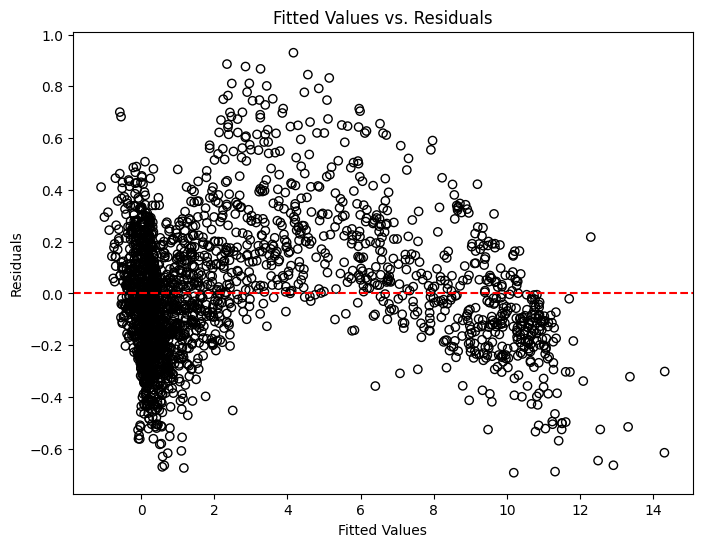

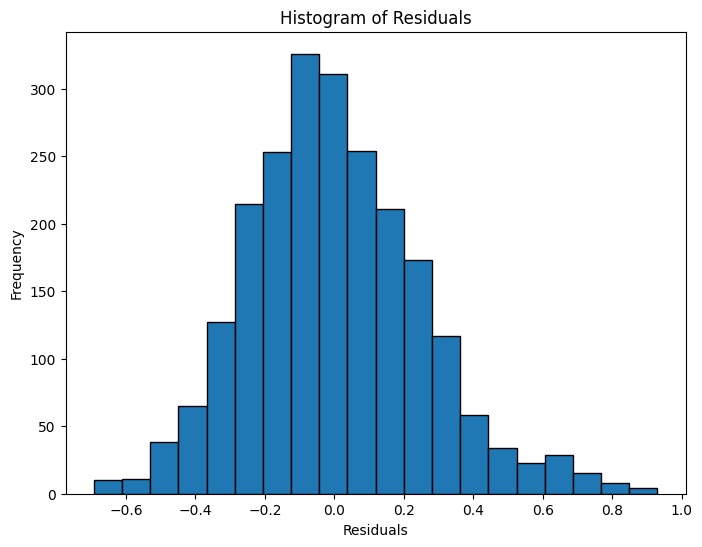

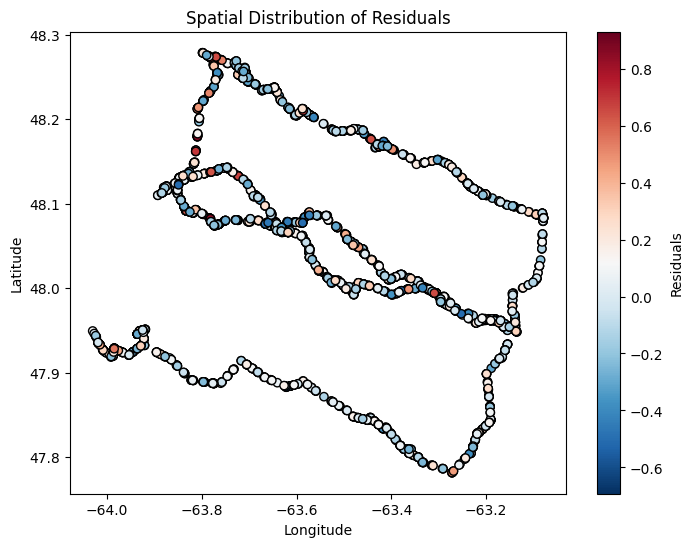

In [22]:
import matplotlib.pyplot as plt

# Extract fitted values and residuals from the GWR results
# gwr_results.predy returns predicted values and resid_response returns residuals.
fitted_values = gwr_results.predy.flatten()
residuals = gwr_results.resid_response.flatten()

# 1. Fitted vs. Residuals Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs. Residuals")
plt.show()

# 2. Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='k')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# 3. Spatial Distribution of Residuals
# Here we use the geographic coordinates (longitude, latitude) to plot the residuals.
plt.figure(figsize=(8, 6))
sc = plt.scatter(coords[:, 0], coords[:, 1], c=residuals, cmap='RdBu_r', edgecolor='k')
plt.colorbar(sc, label="Residuals")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Residuals")
plt.show()
